# <center><font color = 'orange'> **Model selection** </font></center>  

##### Why can’t you train your machine learning algorithm on your dataset and use predictions from this same dataset to evaluate machine learning algorithms? The simple answer is overfitting. Imagine an algorithm that remembers every observation it is shown during training. If you evaluated your machine learning algorithm on the same dataset used to train the algorithm, then an algorithm like this would have a perfect score on the training dataset. But the predictions it made on new data would be terrible. We must evaluate our machine learning algorithms on data that is not used to train the algorithm. The evaluation is an estimate that we can use to talk about how well we think the algorithm may actually do in practice. It is not a guarantee of performance. Once we estimate the performance of our algorithm, we can then re-train the final algorithm on the entire training dataset and get it ready for operational use. Next up we are going to look at four different techniques that we can use to split up our training dataset and create useful estimates of performance for our machine learning algorithms:  
#### 1.Train Test Split
#### 2.K-fold cross-validation
#### 3.Balanced cross-validation - StratifiedKFold
#### 4.Grid search cv
#### 5.Classification metrics
#### 6.Learning curve


In [180]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.datasets import load_iris

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

In [166]:
X,y = load_iris(return_X_y=True)
print("Les variables: ", load_iris().feature_names)
print("\nLa variabe class: ",load_iris().target_names)

Les variables:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

La variabe class:  ['setosa' 'versicolor' 'virginica']


# <font color = 'red'>Split into Train and Test Sets</font>  
##### The simplest method that we can use to evaluate the performance of a machine learning algorithm is to use different training and testing datasets. We can take our original dataset and split it into two parts. Train the algorithm on the first part, make predictions on the second part and evaluate the predictions against the expected results. The size of the split can depend on the size and specifics of your dataset, although it is common to use 67% of the data for training and the remaining 33% for testing

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

print("Data Train set:",X_train.shape)
print("Data test set:",X_test.shape)
print("\nTarget Train set:",y_train.shape)
print("Target test set:",y_test.shape)

Data Train set: (105, 4)
Data test set: (45, 4)

Target Train set: (105,)
Target test set: (45,)


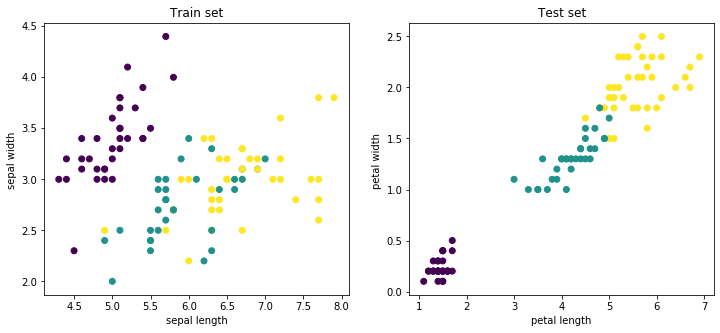

In [88]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.title('Train set')
plt.xlabel('sepal length')
plt.ylabel('sepal width ')
plt.subplot(122)
plt.scatter(X_train[:,2],X_train[:,3],c=y_train)
plt.title('Test set')
plt.xlabel('petal length')
plt.ylabel('petal width ')
plt.show()

In [ ]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print("R2 =",model.score(X_test,y_test))
print('\n Accuracy score = ', accuracy_score(y_test,y_pred))
print('\n Confusion matrix = \n', confusion_matrix(y_test,y_pred))
print('\n Classification report : \n',classification_report(y_test,y_pred))

# <font color="red"> Cross Validation </font>  
##### Cross validation is an approach that you can use to estimate the performance of a machine learning algorithm with less variance than a single train-test set split. It works by splitting the dataset into k-parts (e.g. k = 5 or k = 10). Each split of the data is called a fold. The algorithm is trained on k − 1 folds with one held back and tested on the held back fold. This is repeated so that each fold of the dataset is given a chance to be the held back test set. After running cross validation you end up with k different performance scores that you can summarize using a mean and a standard deviation.  

<img src="cross_val.png" alt="Resumé d'utilisation principal de scikit learn" title="Feuille de scikit learn" width="700" />

In [135]:
models=[]
models.append(('KNN',KNeighborsClassifier()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))

## Evaluate each model
results = []
names = []
scoring = 'neg_log_loss' # 'accuracy', 'roc_auc',  'neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv= 5, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg="%s: %f (%f)" %(name,cv_results.mean(),cv_results.std())
    print(msg)

def best_model(name,res):
    idx_best_model = np.argmax(res)
    return name[idx_best_model]

res = np.mean(results,axis=1)

print("Le meilleur model est :",best_model(names,res))


KNN: 0.961905 (0.055533)
DT: 0.942857 (0.055533)
RF: 0.942857 (0.055533)
NB: 0.942857 (0.046657)
SVM: 0.952381 (0.042592)
Le meilleur model est : KNN


# <font color="red"> Validation Cuvre </font>

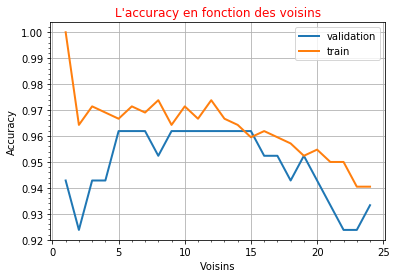

In [175]:
model = KNeighborsClassifier(metric='euclidean')
k = np.arange(1,25)

train_score, val_score = validation_curve(model, X_train, y_train, param_name='n_neighbors',param_range=k,cv=5)

val_score_m  = val_score.mean(axis=1)
train_score_m= train_score.mean(axis=1)

plt.plot(k,val_score_m,label = 'validation',ls="-",linewidth=2)
plt.plot(k,train_score_m,label = 'train',ls="-",linewidth=2)

plt.grid()
plt.minorticks_on()
plt.xlabel("Voisins")
plt.ylabel("Accuracy")
plt.title("L'accuracy en fonction des voisins",color='red')
plt.legend()
plt.show()

##### Overtfit : Les erreurs sur le train diminuent, mais celles sur le test augmentent
    

# <font color="red">GridSearchCV </font>  
#### Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. The example below evaluates different n_neighbors ans distance values for the KNeighbors algorithm on the standard iris dataset. This is a one-dimensional grid search.

# <font color="red"> Classification metrics  </font>  
##### The metrics that you choose to evaluate your machine learning algorithms are very important. Choice of metrics influences how the performance of machine learning algorithms is measured and compared. They influence how you weight the importance of different characteristics in the results and your ultimate choice of which algorithm to choose. In this chapter you will discover how to select and use different machine learning performance metrics in Python with scikit-learn. Let’s get started.  
##### Classification problems are perhaps the most common type of machine learning problem and as such there are a myriad of metrics that can be used to evaluate predictions for these problems.  the most Classification common metrics :  
###### * Classification Accuracy.
###### * Logarithmic Loss.
###### * Area Under ROC Curve.
###### * Confusion Matrix.
###### * Classification Report.  
##### Regression Metrics: the most common metrics for evaluating predictions on regression machine learning problems:
###### *  Mean Absolute Error.
###### * Mean Squared Error.
###### * R2.

In [200]:
n = np.arange(1,20)
d = ['euclidean','manhattan']
param_grid = {'n_neighbors':n, 'metric':d}

grid = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid, cv=5)

grid.fit(X_train,y_train)

print('meilleur modele accuracy: ', grid.best_score_)
print('\nmeilleur paramètre : ', grid.best_params_)

model = grid.best_estimator_

print("l'accuracy : ",model.score(X_test,y_test))

y_pred = model.predict(X_test)
print('____________________________________________________________________')
print('\n Accuracy score = ', accuracy_score(y_test,y_pred))
print('\n Confusion matrix = \n', confusion_matrix(y_test,y_pred))
print('\n Classification report : \n',classification_report(y_test,y_pred))

meilleur modele accuracy:  0.961904761904762

meilleur paramètre :  {'metric': 'euclidean', 'n_neighbors': 5}
l'accuracy :  0.9777777777777777
____________________________________________________________________

 Accuracy score =  0.9777777777777777

 Confusion matrix = 
 [[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]

 Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



# <font color="red">Learning Curve </font>


La taille de chaque ensemble:  [ 8 16 25 33 42 50 58 67 75 84]


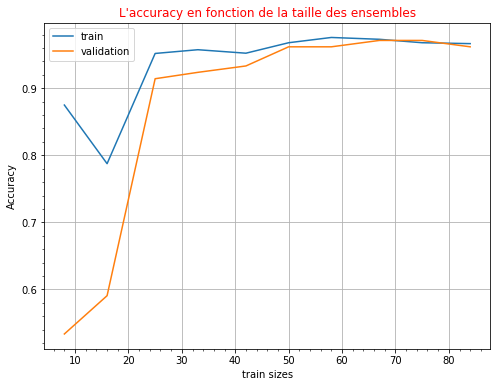

In [211]:

N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1,1,10),cv=5)

print("La taille de chaque ensemble: ",N)

plt.figure(figsize=(8, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1),label='validation')
plt.xlabel('train sizes')
plt.ylabel("Accuracy")
plt.title("L'accuracy en fonction de la taille des ensembles",color='red')
plt.grid()
plt.minorticks_on()
plt.legend()
plt.show()

# <font color='red'>Summary </font>
### In this notebook you discovered statistical techniques that you can use to estimate the performance of your machine learning algorithms.
